In [3]:
import math
from tensorflow.keras.utils import PyDataset
from pathlib import Path
from joblib import Parallel, delayed, parallel_config
import os

import torch
import numpy as np
from tqdm.notebook import tqdm

from evaluation.evaluator import read_ground_truth_files

from pathlib import Path
import itertools
from natsort import natsorted

from transformers import BertTokenizer, BertModel
from joblib import Memory

memory = Memory(".cache", verbose=0)
# memory = Memory(".cache_test", verbose=1)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@memory.cache
def get_tokenizer_model():
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    if DEVICE == "cuda":
        bert_model = BertModel.from_pretrained("bert-base-cased").to(DEVICE)
    else:
        bert_model = BertModel.from_pretrained("bert-base-cased")

    return bert_tokenizer, bert_model

@memory.cache
def read_problem_files(problem_folder, start=0, stop=None):
    # print(f"{start=} {stop=}")
    problems = []
    files = itertools.islice(natsorted(Path(problem_folder).glob('problem-*.txt')), start, stop)
    for problem_file in files:
        # print(f"{problem_file=}")
        # number = problem_file.name[len("problem-") : -len(".txt")]
        with open(problem_file, 'r', encoding="utf8") as fh:
            problems.append(fh.readlines())
    return problems

def pad_paragraph(paragraph_embedding, desired_length):
    d1, d2, d3 = paragraph_embedding.shape
    # print(f"{paragraph_embedding.shape=}")

    target = torch.zeros(d1, desired_length, d3)
    # print(f"{target.shape=}")
    target[:, :d2, :] = paragraph_embedding

    return target

def get_simple_ground_truth(ground_truth, problem_numbers):
    simple_ground_truth = []
    for num in problem_numbers:
        task_3_ground_truth = ground_truth[f"problem-{num}"]["paragraph-authors"]
        simple_ground_truth.append(task_3_ground_truth)
    return simple_ground_truth

def get_task_3_ground_truth(simple_ground_truth):
    # print(f"{len(simple_ground_truth)=}")
    task_gt = []
    for problem in simple_ground_truth:
        problem_gt = []
        for author1, author2 in itertools.combinations(problem, 2):
            problem_gt.append(int(author1 != author2))
        task_gt.append(problem_gt)
    # print(f"{len(task_gt)=}")
    return task_gt

# TODO: Invert the function get_task_3_ground_truth. Our model will output a bunch of binary labels which need to be converted to the task 3 ground truth format
# Ground truth format (gtf): [1, 2, 2, 2, 2, 3, 2, 2]
# Binary labels for comparisons (bl): [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]
# Each binary label is the result of comparing two paragraphs. 1 means there was an author change, 0 means there was no author change
# For example, bl[0], is the result of comparing gtf[0]=1 and gtf[1]=2. 1 != 2, therefore bl[0] = 1. bl[1]=1 is the result of gtf[0] == gtf[2] (1 == 2)
def get_simple_ground_truth_from_task_3(task_3_ground_truth):
    simple_gt = []
    for problem in task_3_ground_truth:
        # k = n*(n-1)/2
        # n**2 - n - 2k = 0
        coeff = [1, -1, len(problem) * -2]
        roots = np.roots(coeff)
        gt_length = int(roots[roots > 0][0])
        # print(gt_length)

        gt = np.zeros(gt_length, dtype=np.uint8)
        gt[0] = 1
        for i in range(1, gt_length):
            # loop for gt[i]
            num_comparisons = i
            pointer = i - 1
            modified_flag = False
            # print(f"{i=} {num_comparisons=} {pointer=}")
            for gt_i, j in enumerate(range(gt_length-2, 1, -1)[:num_comparisons]):
                # comparison between gt[gt_i] and gt[i]
                # print(f"{gt_i=} {j=} {pointer=} {task_3_ground_truth[pointer]=}")
                bin_label = task_3_ground_truth[pointer]
                if bin_label == 0:
                    # print(f"{gt[i]=} {gt[gt_i]=}")
                    gt[i] = gt[gt_i]
                    modified_flag = True
                    break

                pointer += j
            if not modified_flag:
                # print(f"No modified")
                gt[i] = np.max(gt) + 1
            # print(f"{gt}\n")
        simple_gt.append(gt)
    return simple_gt

def get_cuda_memory(i):
    if not torch.cuda.is_available():
        return 0

    total_memory = torch.cuda.get_device_properties(i).total_memory
    reserved_memory = torch.cuda.memory_reserved(i)
    allocated_memory = torch.cuda.memory_allocated(i)
    free_memory = total_memory - (reserved_memory + allocated_memory)
    
    return free_memory / (1024 ** 2) # MB

def flatten_problems(problems_list, squeeze=False):
        # [print(f"{pair=}") for problem in problems_list for pair in problem]
        return [pair.squeeze(0) if squeeze else pair for problem in problems_list for pair in problem]

from itertools import islice
bert_tokenizer, bert_model = get_tokenizer_model()

@memory.cache
def get_problem_embeddings(problems, max_input_length, verbose=False):
    def get_paragraph_pairs(problem_text, max_input_length):
        def get_embeddings(paragraph):
            inputs = bert_tokenizer(paragraph, return_tensors='pt', padding=True, truncation=True)

            # Move inputs to GPU
            if DEVICE == "cuda":
                inputs = {key: value.to(DEVICE) for key, value in inputs.items()}

            # Step 4: Generate embeddings
            with torch.no_grad():
                outputs = bert_model(**inputs)

            # The last hidden state contains the embeddings for each token
            return outputs.last_hidden_state
        # print(problem_text)
        paragraph_embeddings = [pad_paragraph(get_embeddings(para[:max_input_length]), max_input_length) for para in problem_text]
        # print(f"{[paras.shape for paras in paragraph_embeddings]=}")
        # print(f"{[x.shape for x in paragraph_embeddings]}")
        # print(f"{len(paragraph_embeddings)=}")
        pairs = itertools.combinations(paragraph_embeddings, 2)
        return [torch.flatten(torch.stack(pair, dim=2), start_dim=1, end_dim=2) for pair in pairs]
    if verbose:
        return [get_paragraph_pairs(problem_text, max_input_length) for problem_text in tqdm(problems)]
    else:
        return [get_paragraph_pairs(problem_text, max_input_length) for problem_text in problems]

class Pan21PyDataset(PyDataset):
    def __init__(self, x_path, y_path, max_input_length=256, batch_size=128,**kwargs):
        super().__init__(**kwargs)

        self.x_path = x_path
        y = read_ground_truth_files(y_path)
        self.task_3_y = get_task_3_ground_truth(get_simple_ground_truth(y, range(1, len(y)+1)))
        self.task_3_lens = [len(problem) for problem in self.task_3_y]
        self.num_problems = len(self.task_3_y)
        self.pair_end_index = np.cumsum(self.task_3_lens)
        self.num_pairs = np.sum(self.task_3_lens)

        self.max_input_length = max_input_length
        self.batch_size = batch_size

    def __len__(self):
        # Return number of batches.
        return math.ceil(self.num_pairs / self.batch_size)

    def get_data(self, low_problem_idx, high_problem_idx, low_idx, high_idx):
        # print(f"{low_problem_idx=} {high_problem_idx=} {low_idx=} {high_idx=}")
        if high_problem_idx < self.num_problems:
            high_problem_idx += 1
            # print(f"{self.x_path=}")
            embeddings = get_problem_embeddings(read_problem_files(self.x_path, low_problem_idx, high_problem_idx), self.max_input_length)

            batch_x = np.array(flatten_problems(embeddings, squeeze=True)[low_idx:high_idx])
            batch_y = np.array(flatten_problems(self.task_3_y[low_problem_idx:high_problem_idx])[low_idx:high_idx])
        else:
            embeddings = get_problem_embeddings(read_problem_files(self.x_path, low_problem_idx, high_problem_idx+1), self.max_input_length)

            batch_x = np.array(flatten_problems(embeddings, squeeze=True)[low_idx:high_idx])
            batch_y = np.array(flatten_problems(self.task_3_y[low_problem_idx])[low_idx:high_idx])

        # print(f"{self.task_3_y[low_problem_idx:high_problem_idx]=}")
        return batch_x, batch_y

    def __getitem__(self, idx):
        # print(f"{idx=}")
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, self.num_pairs)
        # print(f"{low=} {high=}")

        low_problem_index = 0
        high_problem_index = 0
        low_index_within_problem = 0
        high_index_within_problem = 0
        low_found = False
        for problem_num, (end, num_pairs_in_problem) in enumerate(zip(self.pair_end_index, self.task_3_lens)):
            start = end - num_pairs_in_problem
            if not low_found:
                if end > low:
                    low_problem_index = problem_num
                    low_index_within_problem = low - start
                    low_found = True
            if end >= high:
                high_problem_index = problem_num
                high_index_within_problem = low_index_within_problem + self.batch_size
                break

        batch_x, batch_y = self.get_data(low_problem_index, high_problem_index, low_index_within_problem, high_index_within_problem)

        assert batch_x.shape[0] != 0, f"{idx=}: Dimension is 0 {low_problem_index}, {high_problem_index}, {low_index_within_problem}, {high_index_within_problem}"
        assert batch_x.shape[0] == batch_y.shape[0], f"{idx=}: Dimension mismatch {batch_x.shape=} {batch_y.shape=}"

        return batch_x, batch_y

class Pan21FourierDataset(Pan21PyDataset):
    def __init__(self, x_set, y_set, batch_size=128, num_fourier_features=512, **kwargs):
        super().__init__(x_set, y_set, batch_size=batch_size, **kwargs)
        self.num_fourier_features = num_fourier_features

    def __getitem__(self, idx):
        batch_x_embeddings, batch_y_embeddings = super().__getitem__(idx)

        if self.num_fourier_features == 0:
            pass
        else:
            num_features = batch_x_embeddings.shape[1]
            # print(f"{num_features=}")
            # 0:x will be BERT embeddings for paragraph 1
            # x:length/2 will be fourier features for paragraph 1
            num_non_fourier_features = num_features - self.num_fourier_features
            para1_fourier_features_low, para1_fourier_features_high = num_non_fourier_features // 2, num_features // 2
            para2_fourier_features_low, para2_fourier_features_high = (num_features + num_non_fourier_features) // 2, num_features

            para1_end = num_features//2
            para1_fft = np.real(np.fft.fft(batch_x_embeddings[:, :para1_end, :], axis=1))
            para2_fft = np.real(np.fft.fft(batch_x_embeddings[:, para1_end:, :], axis=1))

            # Simple decimation to fit the spectrum
            factor = num_features // self.num_fourier_features

            batch_x_embeddings[:, para1_fourier_features_low:para1_fourier_features_high] = para1_fft[::factor]
            batch_x_embeddings[:, para2_fourier_features_low:para2_fourier_features_high] = para2_fft[::factor]

        return batch_x_embeddings, batch_y_embeddings

import gc

def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

from scipy.signal import butter, lfilter
# from cupyx.scipy.signal import lfilter

class Pan21FourierFilterDataset(Pan21PyDataset):
    def __init__(self, x_set, y_set,  cutoff_frequencies, **kwargs):
        super().__init__(x_set, y_set, **kwargs)
        
        order = 5
        # clamp freqencies
        cutoff_frequencies = [max(cutoff_frequencies[0], .001), min(cutoff_frequencies[1], .999)]
        
        self.i, self.u = butter(order, cutoff_frequencies, btype='bandstop')
    
    def __getitem__(self, idx, force_compute=False):
        batch_x, batch_y = super().__getitem__(idx)

        _, j, _ = batch_x.shape

        batch_x[:, :j//2, :] = lfilter(self.i, self.u, batch_x[:, :j//2, :], axis=1)
        batch_x[:, j//2:, :] = lfilter(self.i, self.u, batch_x[:, j//2:, :], axis=1)

        return batch_x, batch_y

In [4]:
import json
import math

def map_predictions_to_json(predictions, threshold=0.5):
    # Number of paragraphs inferred from the triangular number formula: n(n-1)/2 = len(predictions)
    # Solving for n gives us n = 3 for len(predictions) = 3

    num_paragraphs = int((1 + math.sqrt(1 + 8 * len(predictions))) / 2)
    
    # Initialize authorship
    authors = list(range(1, num_paragraphs + 1))
    
    # Parse predictions into a matrix (or map) for easier access
    prediction_map = {}
    index = 0
    for i in range(1, num_paragraphs):
        for j in range(i + 1, num_paragraphs + 1):
            prediction_map[(i, j)] = predictions[index]
            index += 1
    print(prediction_map)
    # Clustering logic based on predictions
    for i in range(1, num_paragraphs):
        for j in range(i + 1, num_paragraphs + 1):
            if prediction_map[(i, j)] < threshold:
                # Assign the same author ID to paragraphs i and j if they are likely the same author
                authors[j-1] = authors[i-1]
    
    # Set of unique authors to count different authors
    unique_authors = set(authors)
    
    # Construct the JSON object
    data = {
        "authors": len(unique_authors),
        "structure": [999],  # Placeholder or specific requirement
        "site": "googole.com",
        "multi-author": len(unique_authors) > 1,
        "changes": [int(authors[i] != authors[i + 1]) for i in range(num_paragraphs - 1)],
        "paragraph-authors": authors
    }
    return data

# Example usage with the given array of probabilities
predictions = [0.5, 0.3, 0.4, 0.7, 0.2, 0.1]  # As described for pairs (1-2, 1-3, 2-3)
result_json = map_predictions_to_json(predictions)
print(result_json)

{(1, 2): 0.5, (1, 3): 0.3, (1, 4): 0.4, (2, 3): 0.7, (2, 4): 0.2, (3, 4): 0.1}
{'authors': 2, 'structure': [999], 'site': 'googole.com', 'multi-author': True, 'changes': [1, 1, 0], 'paragraph-authors': [1, 2, 1, 1]}


In [6]:
import tensorflow as tf

import sys 
sys.path.append(r'D:/FER/TAR/Prj/tar_project/evaluation') 

import evaluator
import pandas as pd
import matplotlib.pyplot as plt

predictions_folders = [
    "D:/FER/TAR/Prj/tar_project/Models/0_2024_06_01-11_44_28_AM.keras"
]
truth_folder = "D:/FER/TAR/Prj/tar_project/pan21/validation"

# Read ground truth
truth = read_ground_truth_files(truth_folder)

# Initialize lists to store evaluation results
task1_scores = []
task2_scores = []
task3_scores = []

val_ds = Pan21PyDataset("pan21/validation", "pan21/validation")
nums_of_pars = val_ds.task_3_lens
#print(nums_of_pars)
num_of_pairs = [(pars * (pars - 1)) / 2 for pars in nums_of_pars]
ending_indices = np.cumsum(nums_of_pars)

dict_of_jsons_result = {}
predictions_array = []

# Loop through each model
for model_f in predictions_folders:
    # Load the model
    model = tf.keras.models.load_model(model_f)
    predictions = model.predict(val_ds)
    predictions_array.append(predictions)

472/472 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step


In [7]:
dict_of_jsons_result = {}
for predictions in predictions_array:
    for i, (ending_index, num_of_pair) in enumerate(zip(ending_indices, nums_of_pars)):
        problem_id = i + 1
        prediction = predictions[int(ending_index) - int(num_of_pair):int(ending_index)]
        result_json = map_predictions_to_json(prediction)
        dict_of_jsons_result[f"problem-{problem_id}"] = result_json

{(1, 2): array([0.50747716], dtype=float32), (1, 3): array([0.5226567], dtype=float32), (1, 4): array([0.57818115], dtype=float32), (1, 5): array([0.5756772], dtype=float32), (2, 3): array([0.6810156], dtype=float32), (2, 4): array([0.7277162], dtype=float32), (2, 5): array([0.7256787], dtype=float32), (3, 4): array([0.62769496], dtype=float32), (3, 5): array([0.62529445], dtype=float32), (4, 5): array([0.7042339], dtype=float32)}
{(1, 2): array([0.43697712], dtype=float32), (1, 3): array([0.6386826], dtype=float32), (1, 4): array([0.6083354], dtype=float32), (1, 5): array([0.5341766], dtype=float32), (1, 6): array([0.65701956], dtype=float32), (2, 3): array([0.44025782], dtype=float32), (2, 4): array([0.40867484], dtype=float32), (2, 5): array([0.3378597], dtype=float32), (2, 6): array([0.4601531], dtype=float32), (3, 4): array([0.52036715], dtype=float32), (3, 5): array([0.4447547], dtype=float32), (3, 6): array([0.5722981], dtype=float32), (4, 5): array([0.48379657], dtype=float32),

{(1, 2): array([0.53118396], dtype=float32), (1, 3): array([0.66213286], dtype=float32), (1, 4): array([0.55910397], dtype=float32), (2, 3): array([0.70346045], dtype=float32), (2, 4): array([0.6055259], dtype=float32), (3, 4): array([0.5519695], dtype=float32)}
{(1, 2): array([0.7271574], dtype=float32), (1, 3): array([0.56997734], dtype=float32), (1, 4): array([0.5269071], dtype=float32), (2, 3): array([0.5476552], dtype=float32), (2, 4): array([0.50429356], dtype=float32), (3, 4): array([0.4225754], dtype=float32)}
{(1, 2): array([0.5580825], dtype=float32), (1, 3): array([0.62187815], dtype=float32), (1, 4): array([0.57475984], dtype=float32), (1, 5): array([0.5379741], dtype=float32), (2, 3): array([0.7197368], dtype=float32), (2, 4): array([0.67850864], dtype=float32), (2, 5): array([0.645157], dtype=float32), (3, 4): array([0.68904406], dtype=float32), (3, 5): array([0.6562316], dtype=float32), (4, 5): array([0.5752697], dtype=float32)}
{(1, 2): array([0.6146961], dtype=float32)

{(1, 2): array([0.75750816], dtype=float32), (1, 3): array([0.7278197], dtype=float32), (1, 4): array([0.7763183], dtype=float32), (1, 5): array([0.7756839], dtype=float32), (1, 6): array([0.7166687], dtype=float32), (2, 3): array([0.62210333], dtype=float32), (2, 4): array([0.68118775], dtype=float32), (2, 5): array([0.68039453], dtype=float32), (2, 6): array([0.6089483], dtype=float32), (3, 4): array([0.585781], dtype=float32), (3, 5): array([0.584895], dtype=float32), (3, 6): array([0.50755167], dtype=float32), (4, 5): array([0.67816544], dtype=float32), (4, 6): array([0.6065091], dtype=float32), (5, 6): array([0.5731509], dtype=float32)}
{(1, 2): array([0.4311853], dtype=float32), (1, 3): array([0.35194817], dtype=float32), (1, 4): array([0.42666057], dtype=float32), (1, 5): array([0.5109816], dtype=float32), (1, 6): array([0.3399801], dtype=float32), (1, 7): array([0.37433708], dtype=float32), (2, 3): array([0.5837141], dtype=float32), (2, 4): array([0.65769446], dtype=float32), (

{(1, 2): array([0.65493345], dtype=float32), (1, 3): array([0.76217204], dtype=float32), (1, 4): array([0.6247247], dtype=float32), (1, 5): array([0.62968117], dtype=float32), (1, 6): array([0.70840687], dtype=float32), (1, 7): array([0.5502337], dtype=float32), (1, 8): array([0.70056075], dtype=float32), (1, 9): array([0.6372515], dtype=float32), (1, 10): array([0.6624429], dtype=float32), (1, 11): array([0.69675446], dtype=float32), (1, 12): array([0.67108464], dtype=float32), (1, 13): array([0.72655594], dtype=float32), (1, 14): array([0.69585717], dtype=float32), (2, 3): array([0.72614086], dtype=float32), (2, 4): array([0.5793623], dtype=float32), (2, 5): array([0.5845195], dtype=float32), (2, 6): array([0.66778064], dtype=float32), (2, 7): array([0.50302994], dtype=float32), (2, 8): array([0.65936697], dtype=float32), (2, 9): array([0.59241533], dtype=float32), (2, 10): array([0.6188582], dtype=float32), (2, 11): array([0.6552947], dtype=float32), (2, 12): array([0.62798905], dty

{(1, 2): array([0.53250325], dtype=float32), (1, 3): array([0.6937529], dtype=float32), (1, 4): array([0.66197455], dtype=float32), (1, 5): array([0.6440166], dtype=float32), (1, 6): array([0.5944873], dtype=float32), (1, 7): array([0.4348314], dtype=float32), (1, 8): array([0.68093383], dtype=float32), (1, 9): array([0.670208], dtype=float32), (2, 3): array([0.552485], dtype=float32), (2, 4): array([0.51626897], dtype=float32), (2, 5): array([0.49645826], dtype=float32), (2, 6): array([0.4441194], dtype=float32), (2, 7): array([0.29542634], dtype=float32), (2, 8): array([0.5376932], dtype=float32), (2, 9): array([0.52550757], dtype=float32), (3, 4): array([0.5307088], dtype=float32), (3, 5): array([0.51092935], dtype=float32), (3, 6): array([0.4584538], dtype=float32), (3, 7): array([0.3076174], dtype=float32), (3, 8): array([0.55204844], dtype=float32), (3, 9): array([0.53991735], dtype=float32), (4, 5): array([0.62552726], dtype=float32), (4, 6): array([0.5751227], dtype=float32), (

{(1, 2): array([0.6315079], dtype=float32), (1, 3): array([0.57478386], dtype=float32), (1, 4): array([0.63880974], dtype=float32), (1, 5): array([0.5673061], dtype=float32), (1, 6): array([0.52217615], dtype=float32), (1, 7): array([0.61017036], dtype=float32), (1, 8): array([0.62078154], dtype=float32), (1, 9): array([0.5826924], dtype=float32), (1, 10): array([0.6832608], dtype=float32), (1, 11): array([0.69012487], dtype=float32), (1, 12): array([0.5983186], dtype=float32), (1, 13): array([0.5394337], dtype=float32), (1, 14): array([0.45900637], dtype=float32), (1, 15): array([0.66496843], dtype=float32), (1, 16): array([0.52662915], dtype=float32), (2, 3): array([0.57091415], dtype=float32), (2, 4): array([0.63515294], dtype=float32), (2, 5): array([0.56342006], dtype=float32), (2, 6): array([0.518229], dtype=float32), (2, 7): array([0.60640216], dtype=float32), (2, 8): array([0.6170516], dtype=float32), (2, 9): array([0.57884204], dtype=float32), (2, 10): array([0.6798284], dtype

{(1, 2): array([0.5751219], dtype=float32), (1, 3): array([0.68974376], dtype=float32), (1, 4): array([0.5063404], dtype=float32), (1, 5): array([0.57853544], dtype=float32), (1, 6): array([0.7045709], dtype=float32), (1, 7): array([0.536486], dtype=float32), (1, 8): array([0.649662], dtype=float32), (2, 3): array([0.66738945], dtype=float32), (2, 4): array([0.4807202], dtype=float32), (2, 5): array([0.55335706], dtype=float32), (2, 6): array([0.6827935], dtype=float32), (2, 7): array([0.5109191], dtype=float32), (2, 8): array([0.62598574], dtype=float32), (3, 4): array([0.5280787], dtype=float32), (3, 5): array([0.5996085], dtype=float32), (3, 6): array([0.72236633], dtype=float32), (3, 7): array([0.5580554], dtype=float32), (3, 8): array([0.66921216], dtype=float32), (4, 5): array([0.49455538], dtype=float32), (4, 6): array([0.6296268], dtype=float32), (4, 7): array([0.45206273], dtype=float32), (4, 8): array([0.5693035], dtype=float32), (5, 6): array([0.637541], dtype=float32), (5, 

{(1, 2): array([0.5558299], dtype=float32), (1, 3): array([0.5944996], dtype=float32), (1, 4): array([0.48809993], dtype=float32), (1, 5): array([0.6358807], dtype=float32), (1, 6): array([0.62255216], dtype=float32), (1, 7): array([0.5320831], dtype=float32), (1, 8): array([0.6091601], dtype=float32), (1, 9): array([0.56480885], dtype=float32), (1, 10): array([0.57214725], dtype=float32), (1, 11): array([0.6496077], dtype=float32), (1, 12): array([0.60855097], dtype=float32), (1, 13): array([0.62538075], dtype=float32), (1, 14): array([0.64772165], dtype=float32), (1, 15): array([0.5834096], dtype=float32), (1, 16): array([0.49069095], dtype=float32), (1, 17): array([0.56884444], dtype=float32), (1, 18): array([0.5700955], dtype=float32), (1, 19): array([0.6603725], dtype=float32), (1, 20): array([0.59664226], dtype=float32), (1, 21): array([0.4864767], dtype=float32), (1, 22): array([0.5206933], dtype=float32), (1, 23): array([0.5158471], dtype=float32), (1, 24): array([0.6243974], d

{(1, 2): array([0.69172907], dtype=float32), (1, 3): array([0.6804817], dtype=float32), (1, 4): array([0.64315164], dtype=float32), (1, 5): array([0.5924959], dtype=float32), (1, 6): array([0.5524979], dtype=float32), (1, 7): array([0.59653175], dtype=float32), (2, 3): array([0.73244524], dtype=float32), (2, 4): array([0.6984962], dtype=float32), (2, 5): array([0.6514391], dtype=float32), (2, 6): array([0.6134521], dtype=float32), (2, 7): array([0.6552309], dtype=float32), (3, 4): array([0.63362694], dtype=float32), (3, 5): array([0.5824969], dtype=float32), (3, 6): array([0.5422757], dtype=float32), (3, 7): array([0.58656263], dtype=float32), (4, 5): array([0.63768435], dtype=float32), (4, 6): array([0.5991208], dtype=float32), (4, 7): array([0.64154345], dtype=float32), (5, 6): array([0.55383587], dtype=float32), (5, 7): array([0.5978339], dtype=float32), (6, 7): array([0.5442315], dtype=float32)}
{(1, 2): array([0.46262947], dtype=float32), (1, 3): array([0.52385294], dtype=float32)

                                               Model  Task 1 Score  \
0  D:/FER/TAR/Prj/tar_project/Models/0_2024_06_01...      0.540235   

   Task 2 Score  Task 3 Score  
0      0.536648      0.301276  


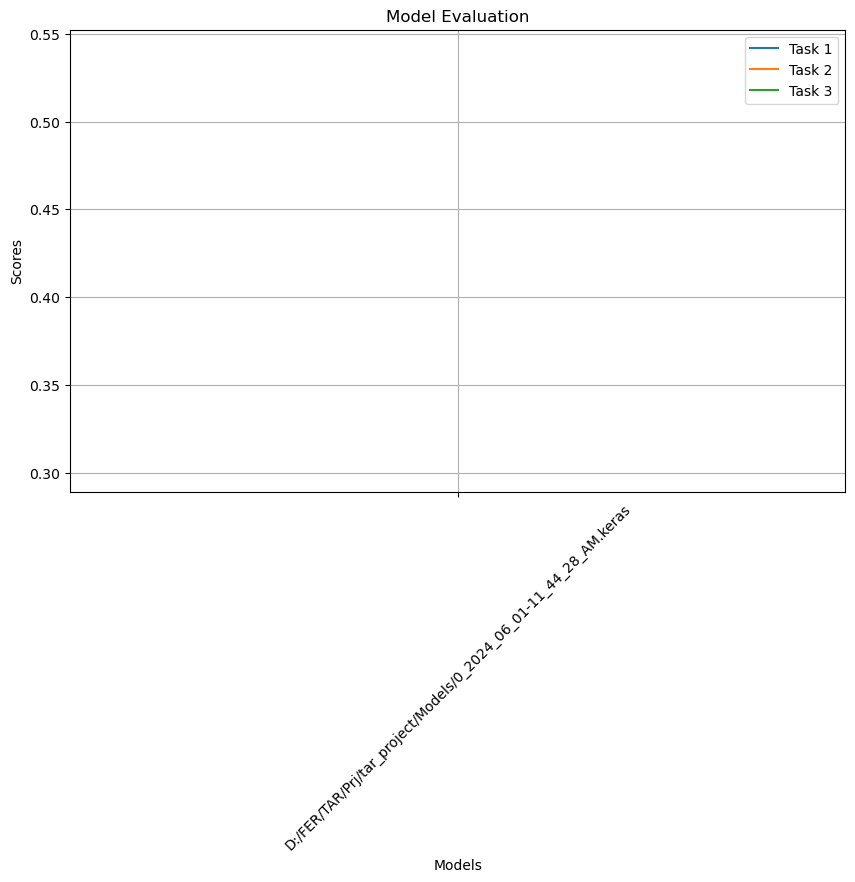

In [9]:
task1_result = evaluator.compute_score_single_predictions(truth, dict_of_jsons_result, 'multi-author')
task2_result = evaluator.compute_score_multiple_predictions(truth, dict_of_jsons_result, 'changes', labels=[0, 1])
task3_result = evaluator.compute_score_multiple_predictions(truth, dict_of_jsons_result, 'paragraph-authors', labels=[1, 2, 3, 4])

#     # Append scores to the lists
task1_scores.append(task1_result)
task2_scores.append(task2_result)
task3_scores.append(task3_result)

# Create a DataFrame to store the evaluation results
results_df = pd.DataFrame({
    'Model': predictions_folders,
    'Task 1 Score': task1_scores,
    'Task 2 Score': task2_scores,
    'Task 3 Score': task3_scores
})

# Display the results DataFrame
print(results_df)

# Plotting the evaluation results
plt.figure(figsize=(10, 6))

plt.plot(predictions_folders, task1_scores, label='Task 1')
plt.plot(predictions_folders, task2_scores, label='Task 2')
plt.plot(predictions_folders, task3_scores, label='Task 3')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Evaluation')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
task3_result = evaluator.compute_score_multiple_predictions(truth, dict_of_jsons_result, 'paragraph-authors', labels=[1, 2, 3, 4])

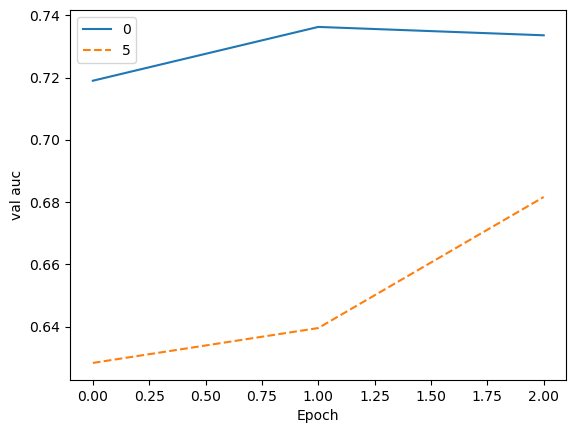

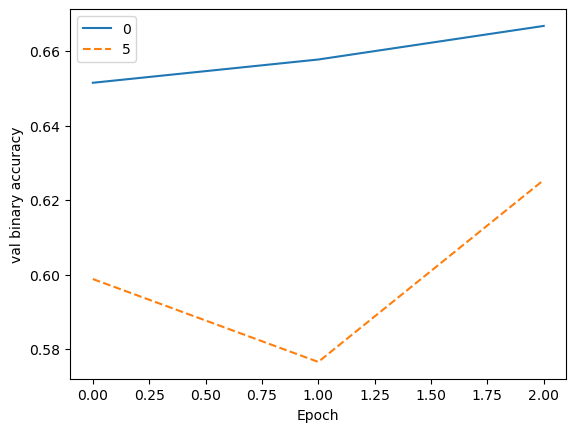

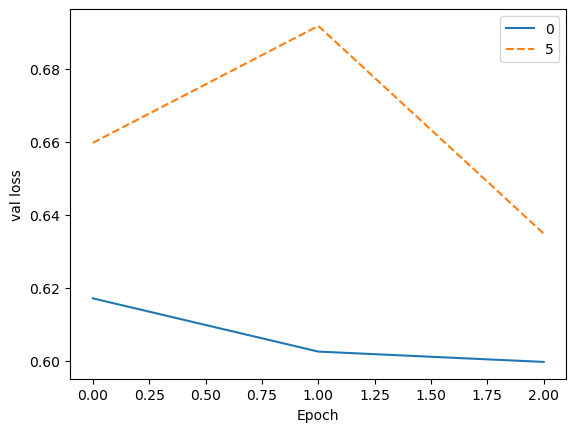

In [27]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import re
from natsort import natsorted 

# Directory where the logs are stored
model_dir = Path("./logs")
log_dfs = []

# Loop through sorted log files
for log_path in natsorted(model_dir.glob('*.log')):
    num_regex = "\d*(?=_)"

    # Extracting the number of Fourier features from the filename
    num_fourier_features = re.search(num_regex, log_path.stem)[0]

    # Reading the log file
    log_df = pd.read_csv(log_path, sep=',', engine='python')
    log_df.columns = ["epoch", "auc", "binary_accuracy", "loss", "val_auc", "val_binary_accuracy", "val_loss"]
    log_df["num_fourier"] = [num_fourier_features] * len(log_df["epoch"])
    log_dfs.append(log_df)

# Concatenate all DataFrame into one
df = pd.concat(log_dfs)

# Validation metrics to plot
val_metrics = ["val_auc", "val_binary_accuracy", "val_loss"]

# Line styles for different Fourier feature counts
line_styles = ['-', '--', '-.', ':', 'solid', 'dotted']

# Create a plot for each validation metric
for metric in val_metrics:
    plt.figure()
    
    # Group by number of Fourier features and plot each group with different line styles
    for (num_fourier, group_df), line_style in zip(df.groupby("num_fourier"), line_styles):
        group_df.plot(x="epoch", y=metric, label=f'{num_fourier}', ax=plt.gca(), linestyle=line_style)

    # Adding labels and title
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace('_', ' '))
    
    # Show the legend
    plt.legend()
    
    # Display the plot
    plt.show()